In [1]:
import json
import requests
import pandas as pd
import string

import torch
import torch.nn as nn
import torch.optim
from torch.autograd import Variable

import re 
from collections import Counter #搜集器，可以让统计词频更简单

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


In [45]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk

In [8]:
train=pd.read_csv('D:/work/homework/fakenews/train.csv')
test=pd.read_csv('D:/work/homework/fakenews/test.csv')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
id        20800 non-null int64
title     20242 non-null object
author    18843 non-null object
text      20761 non-null object
label     20800 non-null int64
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [10]:
train=train.fillna(' ')
train[:10]

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,,Ever wonder how Britain’s most iconic pop pian...,1
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,,Donald J. Trump is scheduled to make a highly ...,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0


In [37]:
train['total'] = train['title'] + ' ' +train['author']  #+ ' '+ train['text']

In [38]:
train.head()

,id,title,author,text,label,total
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


In [9]:
Title=train['title']

In [10]:
len(Title)

20800

In [39]:
true_file2=train[train['label']==0]['total'].values
fake_file2=train[train['label']==1]['total'].values

In [40]:
with open('D:/work/homework/fakenews/true_file2.txt','w',encoding='UTF-8') as f:
    data=f.writelines([line+ '\n' for line in true_file2])

with open('D:/work/homework/fakenews/fake_file2.txt','w',encoding='UTF-8') as f:
    data=f.writelines([line+ '\n' for line in fake_file2])

In [41]:
# 将文本中的标点符号过滤掉
def filter_punc(sentence):
    for c in string.punctuation: #去标点 
        sentence = sentence.replace(c, ' ')
    return(sentence)

In [29]:
#未用，全部特征加进去本机跑不出来
def Tfidf(corpus) :
    vectorizer = CountVectorizer(stop_words='english')   #stop_words='english' 
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(vectorizer.fit_transform(corpus))  
    words = vectorizer.get_feature_names()
    return words

In [61]:
#扫描所有的文本，分词、建立词典，分出正向还是负向的评论，is_filter可以过滤是否筛选掉标点符号
def Prepare_data(good_file, bad_file, is_filter = True):
#    stopset = set(stopwords.words('english'))
    all_words = [] #存储所有的单词
    pos_sentences = [] #存储正向的评论
    neg_sentences = [] #存储负向的评论
    with open(good_file, 'r',encoding='UTF-8') as fr:
        for idx, line in enumerate(fr):
            if is_filter:
                #过滤标点符号
                line = filter_punc(line)
            #分词，去停用词
            tokens=word_tokenize(line)
            words = [z.lower() for z in tokens]
            if len(words) > 0:
                all_words += words
                pos_sentences.append(words)
    print('{0} 包含 {1} 行, {2} 个词.'.format(good_file, idx+1, len(all_words)))

    count = len(all_words)
    with open(bad_file, 'r',encoding='UTF-8') as fr:
        for idx, line in enumerate(fr):
            if is_filter:
                line = filter_punc(line)
            tokens=word_tokenize(line)
            words = [z.lower() for z in tokens]
 #           words = [z for z in tokens if not z in stopset]
            if len(words) > 0:
                all_words += words
                neg_sentences.append(words)
    print('{0} 包含 {1} 行, {2} 个词.'.format(bad_file, idx+1, len(all_words)-count))

    #建立词典，diction的每一项为{w:[id, 单词出现次数]}
    diction = {}
    cnt = Counter(all_words)
    for word, freq in cnt.items():
        diction[word] = [len(diction), freq]
    print('字典大小：{}'.format(len(diction)))
    return(pos_sentences, neg_sentences, diction)

In [52]:
good_file = 'D:/work/homework/fakenews/true_file2.txt'
bad_file ='D:/work/homework/fakenews/fake_file2.txt'

In [57]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Zachary\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [62]:
#根据单词返还单词的编码
def word2index(word, diction):
    if word in diction:
        value = diction[word][0]
    else:
        value = -1
    return(value)

#根据编码获得单词
def index2word(index, diction):
    for w,v in diction.items():
        if v[0] == index:
            return(w)
    return(None)

pos_sentences, neg_sentences, diction = Prepare_data(good_file, bad_file, is_filter = True)
st = sorted([(v[1], w) for w, v in diction.items()])

D:/work/homework/fakenews/true_file2.txt 包含 10387 行, 175069 个词.
D:/work/homework/fakenews/fake_file2.txt 包含 10413 行, 134932 个词.
字典大小：25492


In [63]:
len(diction)

25492

In [64]:
# 输入一个句子和相应的词典，得到这个句子的向量化表示
# 向量的尺寸为词典中词汇的个数，i位置上面的数值为第i个单词在sentence中出现的频率
def sentence2vec(sentence, dictionary):
    vector = np.zeros(len(dictionary))
    for l in sentence:
        vector[l] += 1
    return(1.0 * vector / len(sentence))

# 遍历所有句子，将每一个词映射成编码
dataset = [] #数据集
labels = [] #标签
sentences = [] #原始句子，调试用
# pos/ture
for sentence in pos_sentences:
    new_sentence = []
    for l in sentence:
        if l in diction:
            new_sentence.append(word2index(l, diction))
    dataset.append(sentence2vec(new_sentence, diction))
    labels.append(0) #正标签为0
    sentences.append(sentence)

# neg/fake
for sentence in neg_sentences:
    new_sentence = []
    for l in sentence:
        if l in diction:
            new_sentence.append(word2index(l, diction))
    dataset.append(sentence2vec(new_sentence, diction))
    labels.append(1) #负标签为1
    sentences.append(sentence)

#打乱所有的数据顺序，形成数据集
# indices为所有数据下标的一个全排列
indices = np.random.permutation(len(dataset))

#重新根据打乱的下标生成数据集dataset，标签集labels，以及对应的原始句子sentences
dataset = [dataset[i] for i in indices]
labels = [labels[i] for i in indices]
sentences = [sentences[i] for i in indices]

#对整个数据集进行划分，分为：训练集、校准集和测试集，其中校准和测试集合的长度都是整个数据集的10分之一
test_size = len(dataset) // 10
train_data = dataset[2 * test_size :]
train_label = labels[2 * test_size :]

valid_data = dataset[: test_size]
valid_label = labels[: test_size]

test_data = dataset[test_size : 2 * test_size]
test_label = labels[test_size : 2 * test_size]

In [65]:
# 一个简单的前馈神经网络，三层，第一层线性层，加一个非线性ReLU，第二层线性层，中间有10个隐含层神经元

# 输入维度为词典的大小：每一段评论的词袋模型
model = nn.Sequential(
    nn.Linear(len(diction), 10),
    nn.ReLU(),
    nn.Linear(10, 2),
    nn.LogSoftmax(),
)

def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行num_classes列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素

In [66]:
# 损失函数为交叉熵
cost = torch.nn.NLLLoss()
# 优化算法为Adam，可以自动调节学习率
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
records = []

#循环10个Epoch
losses = []
for epoch in range(10):
    for i, data in enumerate(zip(train_data, train_label)):
        x, y = data
        
        # 需要将输入的数据进行适当的变形，主要是要多出一个batch_size的维度，也即第一个为1的维度
        x = Variable(torch.FloatTensor(x).view(1,-1))
        # x的尺寸：batch_size=1, len_dictionary
        # 标签也要加一层外衣以变成1*1的张量
        y = Variable(torch.LongTensor(np.array([y])))
        # y的尺寸：batch_size=1, 1
        
        # 清空梯度
        optimizer.zero_grad()
        # 模型预测
        predict = model(x)
        # 计算损失函数
        loss = cost(predict, y)
        # 将损失函数数值加入到列表中
        losses.append(loss.data.numpy())
        # 开始进行梯度反传
        loss.backward()
        # 开始对参数进行一步优化
        optimizer.step()
        
        # 每隔3000步，跑一下校验数据集的数据，输出临时结果
        if i % 3000 == 0:
            val_losses = []
            rights = []
            # 在所有校验数据集上实验
            for j, val in enumerate(zip(valid_data, valid_label)):
                x, y = val
                x = Variable(torch.FloatTensor(x).view(1,-1))
                y = Variable(torch.LongTensor(np.array([y])))
                predict = model(x)
                # 调用rightness函数计算准确度
                right = rightness(predict, y)
                rights.append(right)
                loss = cost(predict, y)
                val_losses.append(loss.data.numpy())
                
            # 将校验集合上面的平均准确度计算出来
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print('第{}轮，训练损失：{:.2f}, 校验损失：{:.2f}, 校验准确率: {:.2f}'.format(epoch, np.mean(losses),
                                                                        np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])
            

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


第0轮，训练损失：0.82, 校验损失：0.69, 校验准确率: 0.52
第0轮，训练损失：0.19, 校验损失：0.12, 校验准确率: 0.96
第0轮，训练损失：0.14, 校验损失：0.09, 校验准确率: 0.98
第0轮，训练损失：0.11, 校验损失：0.08, 校验准确率: 0.98
第0轮，训练损失：0.10, 校验损失：0.08, 校验准确率: 0.98
第0轮，训练损失：0.09, 校验损失：0.06, 校验准确率: 0.98
第1轮，训练损失：0.09, 校验损失：0.06, 校验准确率: 0.98
第1轮，训练损失：0.08, 校验损失：0.06, 校验准确率: 0.99
第1轮，训练损失：0.07, 校验损失：0.07, 校验准确率: 0.98
第1轮，训练损失：0.07, 校验损失：0.06, 校验准确率: 0.98
第1轮，训练损失：0.06, 校验损失：0.09, 校验准确率: 0.98
第1轮，训练损失：0.06, 校验损失：0.08, 校验准确率: 0.98
第2轮，训练损失：0.05, 校验损失：0.07, 校验准确率: 0.98
第2轮，训练损失：0.05, 校验损失：0.06, 校验准确率: 0.99
第2轮，训练损失：0.05, 校验损失：0.07, 校验准确率: 0.99
第2轮，训练损失：0.05, 校验损失：0.07, 校验准确率: 0.98
第2轮，训练损失：0.04, 校验损失：0.10, 校验准确率: 0.98
第2轮，训练损失：0.04, 校验损失：0.09, 校验准确率: 0.98
第3轮，训练损失：0.04, 校验损失：0.09, 校验准确率: 0.98
第3轮，训练损失：0.04, 校验损失：0.08, 校验准确率: 0.98
第3轮，训练损失：0.04, 校验损失：0.08, 校验准确率: 0.99
第3轮，训练损失：0.03, 校验损失：0.08, 校验准确率: 0.98
第3轮，训练损失：0.03, 校验损失：0.11, 校验准确率: 0.98
第3轮，训练损失：0.03, 校验损失：0.09, 校验准确率: 0.98
第4轮，训练损失：0.03, 校验损失：0.09, 校验准确率: 0.98
第4轮，训练损失：0.03, 校验损失：0.08, 校验准确率: 0.98
第4轮，训练损失：0.0

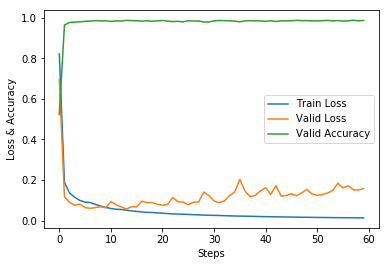

In [67]:
# 绘制误差曲线
a = [i[0] for i in records]
b = [i[1] for i in records]
c = [i[2] for i in records]
plt.plot(a, label = 'Train Loss')
plt.plot(b, label = 'Valid Loss')
plt.plot(c, label = 'Valid Accuracy')
plt.xlabel('Steps')
plt.ylabel('Loss & Accuracy')
plt.legend()

Text(0, 0.5, 'Weights')

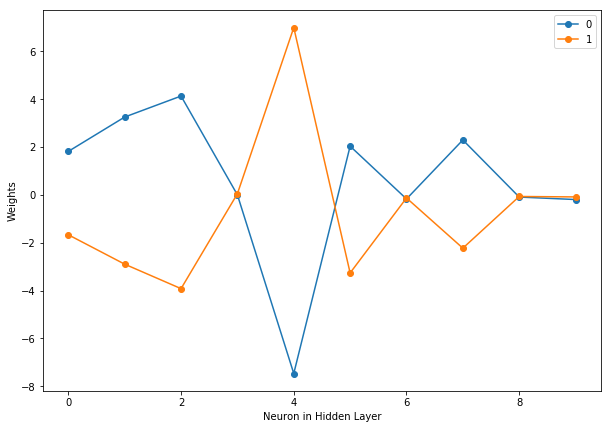

In [68]:
# 绘制出第二个全链接层的权重大小
# model[2]即提取第2层，网络一共4层，第0层为线性神经元，第1层为ReLU，第2层为第二层神经原链接，第3层为logsoftmax
plt.figure(figsize = (10, 7))
for i in range(model[2].weight.size()[0]):
    #if i == 1:
        weights = model[2].weight[i].data.numpy()
        plt.plot(weights, 'o-', label = i)
plt.legend()
plt.xlabel('Neuron in Hidden Layer')
plt.ylabel('Weights')

In [69]:
# 将第二层的各个神经元与输入层的链接权重，挑出来最大的权重和最小的权重，并考察每一个权重所对应的单词是什么，把单词打印出来
# model[0]是取出第一层的神经元

# for i in range(len(model[0].weight)):
i=9
print('\n')
print('第{}个神经元'.format(i))
print('max:')
st = sorted([(w,i) for i,w in enumerate(model[0].weight[i].data.numpy())])
for i in range(1, 20):
    word = index2word(st[-i][1],diction)
    print(word)
print('min:')
for i in range(20):
    word = index2word(st[i][1],diction)
    print(word)




第9个神经元
max:
goalposts
disturb
gaslighting
expect
supports
snl
heed
submission
eurasian
alpha
genre
bone
origin
scrambles
rare
1970s
renewed
004
plutonium
min:
would
proposal
margot
for
new
times
conditions
sanger
york
health
republican
the
pre
existing
undermine
katz
coverage
repairs
cuomo
peddling
